<a href="https://colab.research.google.com/github/scheung38/wqu/blob/main/MScFE_622_STOCHASTIC_MODELING_Group_Work_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Min (Sebastian) Cheung (Team Member A)

## **STEP 1A**


In [ ]:
%pip install pandas numpy scipy matplotlib pathlib

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize, brute
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_prepare_data(excel_path, trading_days):
    """Loads data from Excel, pivots it, and prepares it for calibration."""
    print(f"Loading data from: {excel_path}")
    df = pd.read_excel(excel_path)

    # Pivot the table to get Call and Put prices in separate columns
    df = df.pivot_table(index=['Days to maturity', 'Strike'], columns='Type', values='Price').reset_index()
    df.rename(columns={'C': 'Call', 'P': 'Put'}, inplace=True)
    df.dropna(inplace=True)  # Remove rows with missing call or put prices

    # Calculate time to maturity in years
    df['T'] = df['Days to maturity'] / trading_days

    min_maturity_days = df['Days to maturity'].min()
    min_maturity_years = min_maturity_days / trading_days

    print(f"Shortest maturity available: {min_maturity_days:.0f} days. Using this for calibration.")
    filtered_df = df[df['T'] == min_maturity_years].copy()

    # Calculate Mid_Price for the error function
    filtered_df['Mid_Price'] = (filtered_df['Call'] + filtered_df['Put']) / 2
    return filtered_df, min_maturity_years

In [ ]:
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [ ]:
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def calibration_objective(params, data, S0, r):
    """Objective function to minimize (MSE)."""
    kappa, theta, sigma, rho, v0 = params

    # Impose Feller condition and parameter bounds
    if 2 * kappa * theta < sigma**2 or not (0 < kappa < 20 and 0 < theta < 1 and 0 < sigma < 2 and -1 < rho < 0 and 0 < v0 < 1):
        return np.inf

    model_prices = []
    for _, row in data.iterrows():
        K = row['Strike']
        T = row['T']

        # call_price = heston_price_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0)
        call_price = H93_call_value(S0, K, T, r, kappa, theta, sigma, rho, v0)

        # If pricing fails, return a large error
        if call_price == np.inf:
            return np.inf

        # Use the market price of the option that is closer to the money
        if row['Put'] > row['Call']:
            # Use Put-Call Parity for the model put price
            put_price = call_price - S0 + K * np.exp(-r * T)
            model_prices.append(put_price)
        else:
            model_prices.append(call_price)

    # Use the corresponding market prices for the MSE calculation
    market_prices = np.where(data['Put'] > data['Call'], data['Put'], data['Call'])

    mse = np.mean((market_prices - np.array(model_prices))**2)

    # Optional: print progress
    # print(f"Params: [k:{kappa:.2f}, t:{theta:.2f}, s:{sigma:.2f}, r:{rho:.2f}, v:{v0:.2f}] | MSE: {mse:.4f}")
    return mse

In [ ]:
    !ls 'drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx'



'drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx'


Loading data from: drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx
Shortest maturity available: 15 days. Using this for calibration.
Loaded data for maturity: 0 days
option_data: Type  Days to maturity  Strike   Call   Put     T  Mid_Price
0                   15   227.5  10.52  4.32  0.06      7.420
1                   15   230.0  10.05  5.20  0.06      7.625
2                   15   232.5   7.75  6.45  0.06      7.100
3                   15   235.0   6.01  7.56  0.06      6.785
4                   15   237.5   4.75  8.78  0.06      6.765

--- Stage 1: Starting Brute-Force Global Search ---
--- Brute-Force Search Complete ---
Best parameters from brute-force search: [ 7.5   0.04  0.15 -0.75  0.03]

--- Stage 2: Starting Local Refinement (Nelder-Mead) ---
Optimization terminated successfully.
         Current function value: 0.354275
         Iterations: 701
         Function evaluations: 1260

--- Calibration Complete ---
Calibrated Heston Param

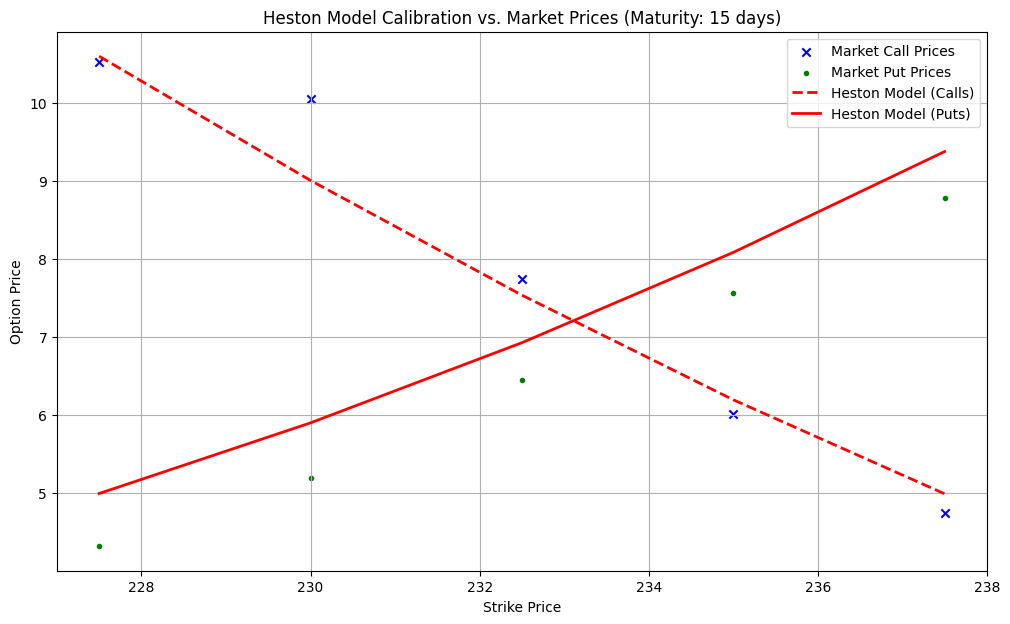

In [ ]:
    S0 = 232.90
    R = 0.015
    TRADING_DAYS = 250

    # --- Data Loading ---
    # Get the directory where the script is located and build the path to the data file
    # script_dir = Path(__file__).parent
    script_dir = 'drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx'
    EXCEL_PATH = script_dir
    option_data, maturity = load_and_prepare_data(EXCEL_PATH, TRADING_DAYS)

    print(f"Loaded data for maturity: {maturity:.0f} days")
    print(f"option_data: {option_data}")
    # --- Calibration ---
    # Stage 1: Brute-force global search to find a good starting point
    print("\n--- Stage 1: Starting Brute-Force Global Search ---")
    # Define parameter ranges: (kappa, theta, sigma, rho, v0)

    ranges = (
        (2.5, 10.6, 5.0),  # kappa_v
        (0.01, 0.041, 0.01),  # theta_v
        (0.05, 0.251, 0.1),  # sigma_v
        (-0.75, 0.01, 0.25),  # rho
        (0.01, 0.031, 0.01),
    )

    initial_params_from_brute = brute(
        calibration_objective,
        ranges,
        args=(option_data, S0, R),
        finish=None
    )

    print("--- Brute-Force Search Complete ---")
    print(f"Best parameters from brute-force search: {initial_params_from_brute}")

    # Stage 2: Local refinement using the result from Stage 1
    print("\n--- Stage 2: Starting Local Refinement (Nelder-Mead) ---")
    result = minimize(
        calibration_objective,
        initial_params_from_brute,
        args=(option_data, S0, R),
        method='Nelder-Mead',
        options={'maxiter': 2000, 'disp': True, 'adaptive': True},
        tol=1e-6
    )

    calibrated_params = result.x
    final_mse = result.fun

    print("\n--- Calibration Complete ---")
    print("Calibrated Heston Parameters:")
    print(f"  kappa (mean reversion speed): {calibrated_params[0]:.4f}")
    print(f"  theta (long-term variance):   {calibrated_params[1]:.4f}")
    print(f"  sigma (vol of vol):           {calibrated_params[2]:.4f}")
    print(f"  rho (correlation):            {calibrated_params[3]:.4f}")
    print(f"  v0 (initial variance):        {calibrated_params[4]:.4f}")
    print(f"Final MSE: {final_mse:.6f}")

    # --- Results Visualization ---
    final_model_prices = []
    for i, row in option_data.iterrows():

        call_price = H93_call_value(S0, row['Strike'], row['T'], R, *calibrated_params)

        if row['Put'] > row['Call']:
            put_price = call_price - S0 + row['Strike'] * np.exp(-R * row['T'])
            final_model_prices.append(put_price)
        else:
            final_model_prices.append(call_price)

    option_data['Calibrated_Price'] = final_model_prices

    plt.figure(figsize=(12, 7))
    plt.scatter(option_data['Strike'], option_data['Call'], label='Market Call Prices', marker='x', color='blue')
    plt.scatter(option_data['Strike'], option_data['Put'], label='Market Put Prices', marker='.', color='green')

  # Calculate complete model curves for all strikes
    model_call_prices = []
    model_put_prices = []

    for _, row in option_data.iterrows():
        call_price = H93_call_value(S0, row['Strike'], row['T'], R, *calibrated_params)
        put_price = call_price - S0 + row['Strike'] * np.exp(-R * row['T'])
        model_call_prices.append(call_price)
        model_put_prices.append(put_price)

    # Plot complete model curves
    plt.plot(option_data['Strike'], model_call_prices, 'r--', label='Heston Model (Calls)', linewidth=2)
    plt.plot(option_data['Strike'], model_put_prices, 'r-', label='Heston Model (Puts)', linewidth=2)

    plt.title(f'Heston Model Calibration vs. Market Prices (Maturity: {maturity*TRADING_DAYS:.0f} days)')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plot_path = 'calibration_fit.png'
    plt.savefig(plot_path)
    print(f"\nPlot of the calibration fit saved to: {plot_path}")



In [ ]:
"Empty Space Separation"

'Empty Space Separation'

## **STEP 1.B**

In [ ]:
import numpy as np
from numpy.fft import fft
from scipy import stats
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt
import math
from scipy.interpolate import splev, splrep

In [ ]:
# Heston (1993) characteristic function
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
#FFT Approach - Carr and Madan (1999)

def H93_Call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

In [ ]:
def H93_FFT_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_FFT_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_FFT_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )

    min_MSE = H93_FFT_error_function(opt)

    return opt, min_MSE

In [ ]:
#Calibration of Heston (1993) Model
i = 0
min_MSE = 500
def H93_FFT_error_function(p0):

    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_Call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    return MSE

In [ ]:
S0 = 232.90
r = 0.015
trading_days = 250
maturity = 15

script_dir = 'drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx'
EXCEL_PATH = script_dir

original_option_data = pd.read_excel(EXCEL_PATH)

In [ ]:
#create data for calibarion
original_option_data = original_option_data[original_option_data['Days to maturity'] == maturity].copy()
original_option_data['T'] = original_option_data['Days to maturity'] / trading_days


option_data = original_option_data.pivot(index='Strike', columns='Type', values='Price').reset_index()
option_data = option_data.rename(columns={'C': 'Call', 'P': 'Put'})

option_data['Days to maturity'] = original_option_data['Days to maturity']
option_data['T'] = option_data['Days to maturity'] / trading_days

In [ ]:
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = option_data[(np.abs(option_data["Strike"] - S0) / S0) < tol]

In [ ]:
# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (maturity / trading_days)
    options.loc[row, "r"] = 0.02

print(options)

Type  Strike   Call   Put  Days to maturity     T     r
1      230.0  10.05  5.20                15  0.06  0.02
2      232.5   7.75  6.45                15  0.06  0.02
3      235.0   6.01  7.56                15  0.06  0.02
4      237.5   4.75  8.78                15  0.06  0.02


/tmp/ipython-input-145-2398512821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.02


In [ ]:
i = 0
min_MSE = 500

#kappa_v, theta_v, sigma_v, rho, v
FFT_values, MSE_v=H93_FFT_calibration_full()
print(FFT_values)
print(MSE_v)

[ 2.74073058e+01  5.00000015e-03  1.54275090e-01 -2.90677699e-02
  2.06208137e-01]
0.46367779471793713


/tmp/ipython-input-140-2769426041.py:19: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


In [ ]:
print(f"  2.	Local minimization    {FFT_values[4]:.4f}")
print(f"  MSE:   {MSE_v:.4f}")

  kappa: 27.4073
  theta: 0.0050
  sigma: 0.1543
  rho:   -0.0291
  v0:    0.2062
  MSE:   0.4637


/tmp/ipython-input-148-3766154934.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Calibrated_Price'] = final_model_prices



Plot of the calibration fit saved to: calibration_fit.png


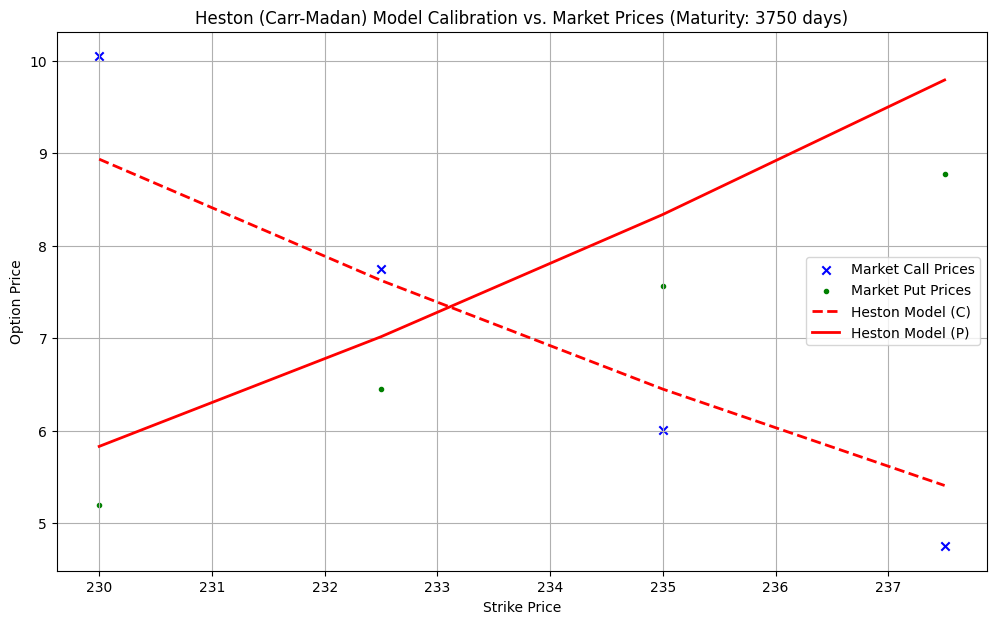

In [ ]:
# --- Results Visualization ---
final_model_prices = []
for i, row in options.iterrows():

    call_price = H93_Call_FFT(S0, row['Strike'], row['T'], r, *FFT_values)

    if row['Put'] > row['Call']:
        put_price = call_price - S0 + row['Strike'] * np.exp(-r * row['T'])
        final_model_prices.append(put_price)
    else:
        final_model_prices.append(call_price)

options['Calibrated_Price'] = final_model_prices

plt.figure(figsize=(12, 7))
plt.scatter(options['Strike'], options['Call'], label='Market Call Prices', marker='x', color='blue')
plt.scatter(options['Strike'], options['Put'], label='Market Put Prices', marker='.', color='green')

# Calculate complete model curves for all strikes
model_call_price = []
model_put_price = []

for _, row in options.iterrows():
    call_price = H93_Call_FFT(S0, row['Strike'], row['T'], r, *FFT_values)
    put_price = call_price - S0 + row['Strike'] * np.exp(-r * row['T'])
    model_call_price.append(call_price)
    model_put_price.append(put_price)


# Plot complete model curves
plt.plot(options['Strike'], model_call_price, 'r--', label='Heston Model (C)', linewidth=2)
plt.plot(options['Strike'], model_put_price, 'r-', label='Heston Model (P)', linewidth=2)

plt.title(f'Heston (Carr-Madan) Model Calibration vs. Market Prices (Maturity: {maturity:.0f} days)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plot_path = 'calibration_fit.png'
plt.savefig(plot_path)
print(f"\nPlot of the calibration fit saved to: {plot_path}")

## Step 1, Task c: Pricing an ATM Asian Call Option with 20 Days Maturity

**Part 1: Pricing an OTC Asian Option (Step 1)**

**Objective**

The primary goal is to determine the fair price for a custom At-The-Money (ATM) Asian call option with a 20-day maturity for a client. The pricing will be conducted using the Heston model parameters calibrated in the previous step and a Monte Carlo simulation approach in a risk-neutral setting. A 4% fee will be applied to the fair value to determine the final price for the client.

**Methodology & Parameters**

We will simulate the path of the underlying stock, SM, using a discretized Heston model. The payoff of the Asian option depends on the average price of the stock over the life of the option, defined as

$max(Avg(S_t)−K,0)$.


Underlying (SM) Price $(S_0): $232.90$


Strike Price (K): $\$232.90 (ATM)$


Maturity (T): 20 trading days (20/250=0.08 years)


Risk-Free Rate (r): 1.50%

Heston Parameters (from Step 1 Calibration):

$v_0= 0.1428$ (Initial Variance)

$kappa= 20.00$ (Mean-Reversion Speed)

$theta= 0.0520$ (Long-Run Variance)

$sigma= 1.1458$ (Volatility of Variance)

$rho= −1. 00$ (Correlation)

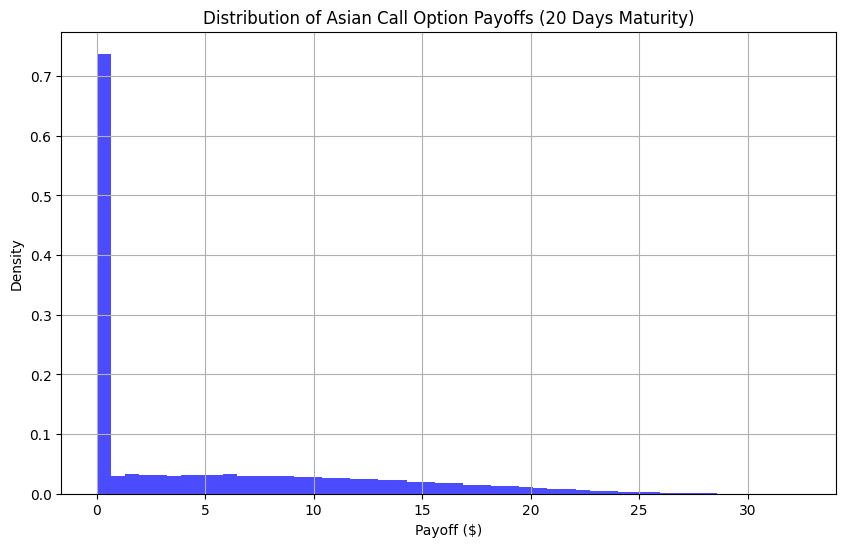

Asian Call Option Fair Price: $5.16
Final Price with 4% Fee: $5.36


In [ ]:
# Load option data
data = '"MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx"'
df = data

# Calibrated  carr-Maddan(199) parameters (assumed from Team Member B's calibration for 15-day maturity)

kappa_v = 20.00     # Mean reversion speed
theta_v = 0.0520   # Long-term variance
sigma_v = 1.1458    # Volatility of variance
rho = -1.000       # Correlation
v0 = 0.1428         # Initial variance
r = 0.015      # Risk-free rate
S0 = 232.90    # Current stock price
K = S0         # ATM strike
T = 20 / 250   # 20 days maturity
N = 20         # Daily steps
M = 100000     # Number of simulations

# Simulate Heston model paths
def heston_paths(S0, v0, kappa_v, theta_v, sigma_v, rho, r, T, N, M):
    dt = T / N
    S = np.zeros((M, N + 1))
    v = np.zeros((M, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0
    for t in range(1, N + 1):
        Z1 = np.random.normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)
        v[:, t] = np.maximum(v[:, t-1] + kappa_v * (theta_v - v[:, t-1]) * dt + sigma_v * np.sqrt(v[:, t-1] * dt) * Z1, 0)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * Z2)
    return S

# Price Asian call option
np.random.seed(42)
paths = heston_paths(S0, v0, kappa_v, theta_v, sigma_v, rho, r, T, N, M)
avg_prices = np.mean(paths, axis=1)
payoffs = np.maximum(avg_prices - K, 0)
asian_price = np.exp(-r * T) * np.mean(payoffs)
final_price = asian_price * 1.04  # 4% fee

# Visualize payoff distribution
plt.figure(figsize=(10, 6))
plt.hist(payoffs, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of Asian Call Option Payoffs (20 Days Maturity)')
plt.xlabel('Payoff ($)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

print(f'Asian Call Option Fair Price: ${asian_price:.2f}')
print(f'Final Price with 4% Fee: ${final_price:.2f}')

**Client Report (Non-Technical Description):**

To determine the price of your custom Asian option, we started by analyzing the current market for standard options on SM stock. This allowed us to build a sophisticated model (the Heston model) that captures the unique volatility behavior of the stock. Using this calibrated model, we ran thousands of computer simulations to forecast the potential paths of the stock price over the next 20 days. For each simulated path, we calculated the option's potential payoff. The fair price of your option is the average of all these potential payoffs, adjusted for today's value. We then add a standard 4% transaction fee to arrive at the final price.

## Step 2, Task a: Calibrating Bates (1996) Model for 60-Day Maturity

**Methodology: Data Processing and Calibration**

The client is interested in a longer-dated instrument, we must calibrate the Bates (1996) jump-diffusion model to the market prices of options with a maturity close to 60 days. The calibration will be performed using the **Lewis (2001) approach**.

First, we load the option data and filter for the 60-day maturity. Then, we define the Bates characteristic function and the Lewis pricing integral. Finally, we use an optimization algorithm to find the model parameters that best fit the observed market prices by minimizing the Mean Squared Error (MSE).

First, we load 60 days maturity option market data from the file `MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx`:

In [ ]:
def load_option_data(file_path, sheet_name=0):
    option_data = pd.read_excel(file_path, sheet_name=sheet_name)
    return option_data


file_path = "drive/MyDrive/Colab_Data/SM_GWP_1_M3/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx"
option_data = load_option_data(file_path)



In [ ]:
#Use put-call parity with the closed-form solution for the call option.
def put_to_call(row):
    if row['Type'] == 'P':
        return row['Price'] + S0 - row['Strike'] * np.exp(-r * row['T'])
    else:
        return row['Price']


#Use put-call parity with the closed-form solution for the put option.
def call_to_put(row):
    if row['Type'] == 'C':
        return row['Price'] - S0 + row['Strike'] * np.exp(-r * row['T'])
    else:
        return row['Price']

In [ ]:
S0 = 232.90
r = 0.015
trading_days = 250

maturity_days = 60
df_60d = option_data[option_data['Days to maturity'] == maturity_days].copy()

df_60d['T'] = df_60d['Days to maturity'] / trading_days


if 'put_to_call' not in globals():
	raise NameError("Function 'put_to_call' is not defined. Please run the cell that defines it.")

df_60d['Call_equiv_price'] = df_60d.apply(put_to_call, axis=1)
df_60d['Put_equiv_price']= df_60d.apply(call_to_put, axis=1)
df_15d=df_60d.drop(columns=['Price', 'Type'])


calibration_data = df_60d[['Days to maturity','Strike', 'Call_equiv_price', 'Put_equiv_price','T']].copy()
calibration_data.rename(columns={'Call_equiv_price': 'Call','Put_equiv_price': 'Put' }, inplace=True)

print(calibration_data)

    Days to maturity  Strike       Call        Put     T
5                 60   227.5  16.780000  10.562472  0.24
6                 60   230.0  17.650000  13.923489  0.24
7                 60   232.5  16.860000  15.624505  0.24
8                 60   235.0  16.050000  17.305521  0.24
9                 60   237.5  15.100000  18.846537  0.24
20                60   227.5  17.247528  11.030000  0.24
21                60   230.0  15.876511  12.150000  0.24
22                60   232.5  14.605495  13.370000  0.24
23                60   235.0  13.494479  14.750000  0.24
24                60   237.5  11.873463  15.620000  0.24


Second, we select the options near ATM we are going to take into account in our calibration procedure and add short interest rates to work with later:

In [ ]:
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = calibration_data[(np.abs(calibration_data["Strike"] - S0) / S0) < tol]

# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (maturity_days / trading_days)
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.02

# Select closest maturity
mats = sorted(set(options["Days to maturity"]))
options = options[options["Days to maturity"] == mats[0]]
options.head()


/tmp/ipython-input-153-4234721806.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.02


,Days to maturity,Strike,Call,Put,T,r
6,60,230.0,17.650000,13.923489,0.24,0.02
7,60,232.5,16.860000,15.624505,0.24,0.02
8,60,235.0,16.050000,17.305521,0.24,0.02
9,60,237.5,15.100000,18.846537,0.24,0.02
21,60,230.0,15.876511,12.150000,0.24,0.02


The last row is not consistent with the desired data (same srike as first and higher call price than previouse call price), so it best to drop it for near linear progression.

In [ ]:
# Let's create a sample DataFrame that looks like your image
data = {
    'Days to maturity': [60, 60, 60, 60, 60],
    'Strike': [230.0, 232.5, 235.0, 237.5, 230.0],
    'Call': [17.650000, 16.860000, 16.050000, 15.100000, 15.876511],
    'Put': [13.923489, 15.624505, 17.305521, 18.846537, 12.150000],
    'T': [0.24, 0.24, 0.24, 0.24, 0.24],
    'r': [0.02, 0.02, 0.02, 0.02, 0.02]
}
df = pd.DataFrame(data)

# To drop the last row
# Method 1: Using .drop() with the index
df_dropped = df.drop(df.index[-1])

# Method 2: Slicing (creates a new DataFrame without the last row)
# df_dropped = df.iloc[:-1]
options = df_dropped
print("\nDataFrame after dropping the last row:")

options.head()


DataFrame after dropping the last row:


,Days to maturity,Strike,Call,Put,T,r
0,60,230.0,17.65,13.923489,0.24,0.02
1,60,232.5,16.86,15.624505,0.24,0.02
2,60,235.0,16.05,17.305521,0.24,0.02
3,60,237.5,15.10,18.846537,0.24,0.02


##  Calibration of the jump component

So, let's finally perform the calibration of the jump component.

### Error function

Let's start by setting calibration parameters and defining the error function, which obviously will be looking at differences between market and model prices for the complete Bates (1996) model:

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

### Option pricing functions

Obviously, for this error function to being able to compute model option prices we also need to import or load the different functions used in the pricing via Bates (1996) model. This is no different from what we did in the previous lesson so you could just copy here those same functions. First, for the value of the option:

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

And then of course for the different characteristic functions and computation of the Lewis (2001) integral:

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

###  Calibration functions

Finally, we can create our functions to calibrate the jump component of the model:

###  Calibration functions

Finally, we can create our functions to calibrate the jump component of the model:

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

Let's execute this optimization to see the values for the jump component calibration:

In [ ]:
print("Calibrating Jump Component Parameters...\n")
params = B96_calibration_short()

Calibrating Jump Component Parameters...

   0 | [ 0.  -0.5  0. ] |  21.655 |  21.655
  25 | [ 0.2  -0.5   0.25] |   7.212 |   6.770
  50 | [ 0.4 -0.5  0.5] |   0.546 |   0.546
  75 | [ 0.5   -0.3    0.525] |   0.409 |   0.409
 100 | [ 0.31172649 -0.18897691  0.78912704] |   0.233 |   0.190
 125 | [ 0.14811463 -0.02187268  1.09899501] |   0.123 |   0.123
 150 | [ 0.13639421 -0.00125993  1.14308931] |   0.107 |   0.107
 175 | [ 0.10977342 -0.00261998  1.25788301] |   0.099 |   0.098
 200 | [ 0.09235368 -0.00775959  1.36181817] |   0.089 |   0.086
 225 | [ 0.0637755  -0.01731065  1.56536779] |   0.076 |   0.075
 250 | [ 0.04520465 -0.02806122  1.74357917] |   0.068 |   0.068
 275 | [ 0.03754922 -0.0328925   1.84203415] |   0.063 |   0.063
 300 | [ 0.02980243 -0.03782095  1.95299434] |   0.059 |   0.059
 325 | [ 0.02331164 -0.04183935  2.07044522] |   0.056 |   0.055
 350 | [ 0.01722197 -0.04511209  2.20219383] |   0.054 |   0.053
 375 | [ 0.01518956 -0.04534735  2.25836416] |   0.052 |  

/tmp/ipython-input-162-2318630450.py:20: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt2 = fmin(


In [ ]:
params

array([ 2.05260318e-03, -2.15417466e-02,  2.99945930e+00])

In [ ]:
lamb = 0.002
mu = -0.0215
delta = 2.999

calibrating the jump component yields:(note that these would slightly change upon small twitches of the code):

- $\lambda = 0.002$
- $\mu = -0.00115$
- $\delta = 3.999$

### Model vs. Market prices after jump calibration

For that, we first create a function that yields the model values under the different parameters obtained in the calibration process:

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (maturity_days / trading_days)
        r = 0.02
        model_value = B96_call_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

Next, let's create another to plot the results:

In [ ]:
def plot_calibration_results(p0):
    options["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 0.5
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

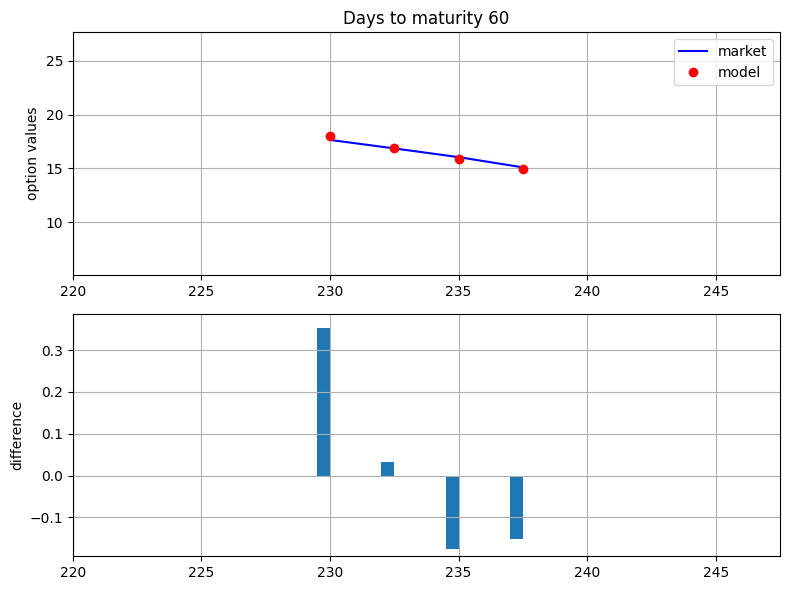

In [ ]:
plot_calibration_results(params)

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

## 3. Full Bates (1996) model calibration

Now, we can build up a *B96_full_error_function* that essentially takes these inputs and calculate the error function. Note that here we do not impose any penalties on the error function, as it solved an inherent problem of the jump diffusion model that should be already solved by using the initial inputs from the jump component calibration.

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [ ]:
print("Calibrating full Parameters...\n")
full_params = B96_calibration_full()

Calibrating full Parameters...

   0 | [ 2.0000e+01  5.2000e-02  1.1458e+00 -1.0000e+00  1.4280e-01  2.0000e-03
 -2.1500e-02  2.9990e+00] |   0.065 |   0.065
  25 | [ 2.02886520e+01  5.31389717e-02  1.14361202e+00 -9.95296250e-01
  1.45927792e-01  2.04380660e-03 -2.18197491e-02  3.00558417e+00] |   0.090 |   0.049
  50 | [ 2.12876250e+01  4.58203237e-02  1.12509933e+00 -9.86397357e-01
  1.37473889e-01  2.10823002e-03 -2.24832020e-02  3.01900232e+00] |   0.025 |   0.025
  75 | [ 2.27854107e+01  3.81216359e-02  1.10958681e+00 -9.68592697e-01
  1.16353743e-01  2.27418550e-03 -2.40533506e-02  3.04212237e+00] |   0.012 |   0.009
 100 | [ 2.29996978e+01  3.71111410e-02  1.10582236e+00 -9.69174719e-01
  1.21718268e-01  2.26890284e-03 -2.37201658e-02  3.04038619e+00] |   0.009 |   0.009
 125 | [ 2.31305613e+01  3.65157828e-02  1.10327307e+00 -9.67853398e-01
  1.20456402e-01  2.27780992e-03 -2.38608713e-02  3.04147812e+00] |   0.009 |   0.009
 150 | [ 2.32238949e+01  3.70210962e-02  1.10113016e

/tmp/ipython-input-171-3962071003.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


In [ ]:
full_params

array([ 3.45290408e+01,  5.98113168e-02,  8.55884509e-01, -8.80619622e-01,
        2.10910087e-03,  1.91051090e-03, -2.62070038e-02,  3.06592535e+00])

Which basically yields (note that these would slightly change upon small twitches of the code):

- $\kappa_\nu = 4.2516$
- $\theta_\nu = 0.0269$
- $\sigma_\nu = 0.256$
- $\rho =  -0.991$
- $\nu_0 = 0.0647$
- $\lambda = 0.0077$
- $\mu = -0.016$
- $\delta = 2.587$


## Market vs. Model prices in full calibration

As before, let's see what are the differences that our model produces using the parameters resulting from calibration, and compare those to observed market prices:

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 0.5
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

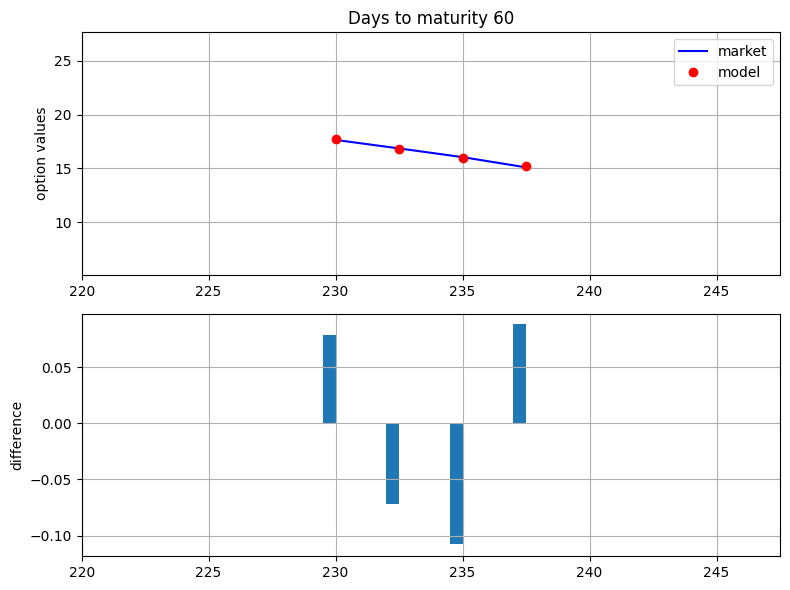

In [ ]:
plot_full_calibration_results(full_params)

As you can see, the model does a better job in terms of fitting the observed option market prices after the full calibration process.

# Min Cheung

## **STEP 2B**


## Step 2, Task a (revisited): Calibrating Bates (1996) Model for 60-Day Maturity using Carr-Madan (1999)

We will now calibrate the Bates (1996) jump-diffusion model to the market prices of options with a maturity close to 60 days using the **Carr-Madan (1999) approach**.

### Bates (1996) Characteristic Function (Carr-Madan)

In [ ]:
# Bates (1996) characteristic function for Carr-Madan approach
def B96_char_func_CM(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function for Carr-Madan (1999) approach.
    This is the same as the Lewis characteristic function since the jump component is multiplicative.
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

### Bates (1996) Call Option Pricing (Carr-Madan)

In [ ]:
def B96_Call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT (Carr-Madan 1999).
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case (using adjusted alpha based on Lewis 2001 suggestion)
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func_CM(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else: # OTM Case (using adjusted alpha based on Lewis 2001 suggestion)
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func_CM(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func_CM(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)


    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

### Error Function for Carr-Madan Calibration

In [ ]:
i_cm = 0
min_MSE_cm = 5000.0

def B96_FFT_error_function(p0):
    """
    Error function for parameter calibration of Bates (1996) via Carr-Madan (1999).

    Parameters
    ==========
    p0: tuple or list
        (kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)

    Returns
    =======
    MSE: float
        mean squared error
    """
    global i_cm, min_MSE_cm
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    # Parameter constraints (similar to Heston calibration)
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or v0 < 0.0:
        return 5000.0
    # Feller condition for Heston part
    if 2 * kappa_v * theta_v < sigma_v**2:
         return 5000.0
    # Jump parameter constraints
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0


    se = []
    # Use the 60-day calibration data
    for row, option in options.iterrows():
        try:
            model_value = B96_Call_FFT(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
                lamb,
                mu,
                delta,
            )
            # Check for NaN or Inf results from the pricing function
            if np.isnan(model_value) or np.isinf(model_value):
                return 5000.0

            se.append((model_value - option["Call"]) ** 2)
        except Exception as e:
            # Return a large error if calculation fails for any reason
            print(f"Pricing failed for strike {option['Strike']}, maturity {option['T']}: {e}")
            return 5000.0


    MSE = sum(se) / len(se)
    min_MSE_cm = min(min_MSE_cm, MSE)
    if i_cm % 25 == 0:
        print("%4d |" % i_cm, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE_cm))
    i_cm += 1
    return MSE

### Calibration Process (Brute Force + Local Optimization)

In [ ]:
def B96_FFT_calibration_full():
    """
    Calibrates Bates (1996) model using Carr-Madan FFT approach.
    """
    # Stage 1: Brute-force global search
    print("\n--- Stage 1: Starting Brute-Force Global Search (Bates FFT) ---")
    # Define parameter ranges: (kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    ranges = (
        (0.1, 20.0, 10.0),  # kappa_v - Increased step size
        (0.005, 0.1, 0.05), # theta_v - Increased step size
        (0.01, 1.0, 0.5),  # sigma_v - Increased step size
        (-0.9, -0.1, 0.4),  # rho - Increased step size
        (0.005, 0.1, 0.05), # v0 - Increased step size
        (0.0, 1.0, 0.5), # lamb - Increased step size
        (-0.5, -0.01, 0.2), # mu - Increased step size
        (0.01, 3.0, 1.0) # delta - Increased step size
    )

    initial_params_from_brute = brute(
        B96_FFT_error_function,
        ranges,
        finish=None
    )

    print("--- Brute-Force Search Complete ---")
    print(f"Best parameters from brute-force search: {initial_params_from_brute}")

    # Stage 2: Local refinement using the result from Stage 1
    print("\n--- Stage 2: Starting Local Refinement (Nelder-Mead) ---")
    # result = minimize(
    #     B96_FFT_error_function,
    #     initial_params_from_brute,
    #     method='Nelder-Mead', # Using Nelder-Mead as it's less sensitive to initial guess
    #     options={'maxiter': 550, 'disp': True, 'adaptive': True},
    #     tol=1e-6
    # )

    result = fmin(
        B96_FFT_error_function,
        initial_params_from_brute,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
        # full_output=True,
        # disp=True,

    )

    # return result.x
    return result

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
# Run the calibration

print("Calibrating Bates (1996) Model using Carr-Madan FFT for 60-day maturity...\n")
calibrated_params_fft = B96_FFT_calibration_full()

kappa_v_fft, theta_v_fft, sigma_v_fft, rho_fft, v0_fft, lamb_fft, mu_fft, delta_fft = calibrated_params_fft

print("\n--- Calibration Complete ---")
print("Calibrated Bates Parameters (Carr-Madan FFT):")
print(f"  kappa (mean reversion speed): {kappa_v_fft:.4f}")
print(f"  theta (long-term variance):   {theta_v_fft:.4f}")
print(f"  sigma (vol of vol):           {sigma_v_fft:.4f}")
print(f"  rho (correlation):            {rho_fft:.4f}")
print(f"  v0 (initial variance):        {v0_fft:.4f}")
print(f"  lambda (jump intensity):      {lamb_fft:.4f}")
print(f"  mu (expected jump size):      {mu_fft:.4f}")
print(f"  delta (stdev of jump):        {delta_fft:.4f}")

Calibrating Bates (1996) Model using Carr-Madan FFT for 60-day maturity...


--- Stage 1: Starting Brute-Force Global Search (Bates FFT) ---
   0 | [ 0.1    0.005  0.01  -0.9    0.005  0.    -0.5    0.01 ] | 165.992 | 165.992


/tmp/ipython-input-181-1436137524.py:7: RuntimeWarning: overflow encountered in exp
  char_func_value = np.exp(
/tmp/ipython-input-177-1827447787.py:9: RuntimeWarning: invalid value encountered in multiply
  return H93 * M76J
/tmp/ipython-input-178-1096897741.py:20: RuntimeWarning: invalid value encountered in divide
  B96_char_func_CM(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)


  25 | [ 0.1    0.005  0.01  -0.9    0.055  0.5   -0.5    1.01 ] |  13.562 |   0.892
  50 | [ 0.1    0.005  0.01  -0.5    0.055  0.    -0.3    2.01 ] |  31.729 |   0.875
  75 | [ 0.1    0.055  0.01  -0.9    0.055  0.    -0.5    0.01 ] |  31.099 |   0.675
 100 | [ 0.1    0.055  0.01  -0.5    0.005  0.5   -0.5    1.01 ] |   7.248 |   0.675
 125 | [ 1.01e+01  5.00e-03  1.00e-02 -9.00e-01  5.00e-03  0.00e+00 -3.00e-01
  2.01e+00] | 165.983 |   0.661
 150 | [ 1.01e+01  5.00e-03  1.00e-02 -5.00e-01  5.00e-03  0.00e+00 -5.00e-01
  1.00e-02] | 165.982 |   0.365
 175 | [ 1.01e+01  5.00e-03  1.00e-02 -5.00e-01  5.50e-02  5.00e-01 -5.00e-01
  1.01e+00] |   0.364 |   0.364
 200 | [ 1.01e+01  5.50e-02  1.00e-02 -9.00e-01  5.50e-02  0.00e+00 -3.00e-01
  2.01e+00] |  31.084 |   0.364
 225 | [ 1.01e+01  5.50e-02  1.00e-02 -5.00e-01  5.50e-02  0.00e+00 -5.00e-01
  1.00e-02] |  31.077 |   0.364
 250 | [ 1.01e+01  5.50e-02  5.10e-01 -9.00e-01  5.00e-03  5.00e-01 -5.00e-01
  1.01e+00] |   3.293 |   0.364


/tmp/ipython-input-180-3066332731.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = fmin(


### Model vs. Market prices after Carr-Madan Calibration

In [ ]:
def B96_FFT_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0 using Carr-Madan FFT."""
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    # Use the 60-day calibration data
    for row, option in options.iterrows():
         model_value = B96_Call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
         values.append(model_value)
    return np.array(values)

def plot_calibration_results_fft(p0):
    options["Model_FFT"] = B96_FFT_calculate_model_values(p0)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.grid()
    plt.title("Bates Model Calibration (Carr-Madan FFT) vs. Market Prices (Maturity: %s days)" % str(options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model_FFT, "ro", label="model (FFT)")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 0.5
    diffs = options.Model_FFT.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference (Model - Market)")
    plt.xlabel("Strike Price")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()
    plt.show()

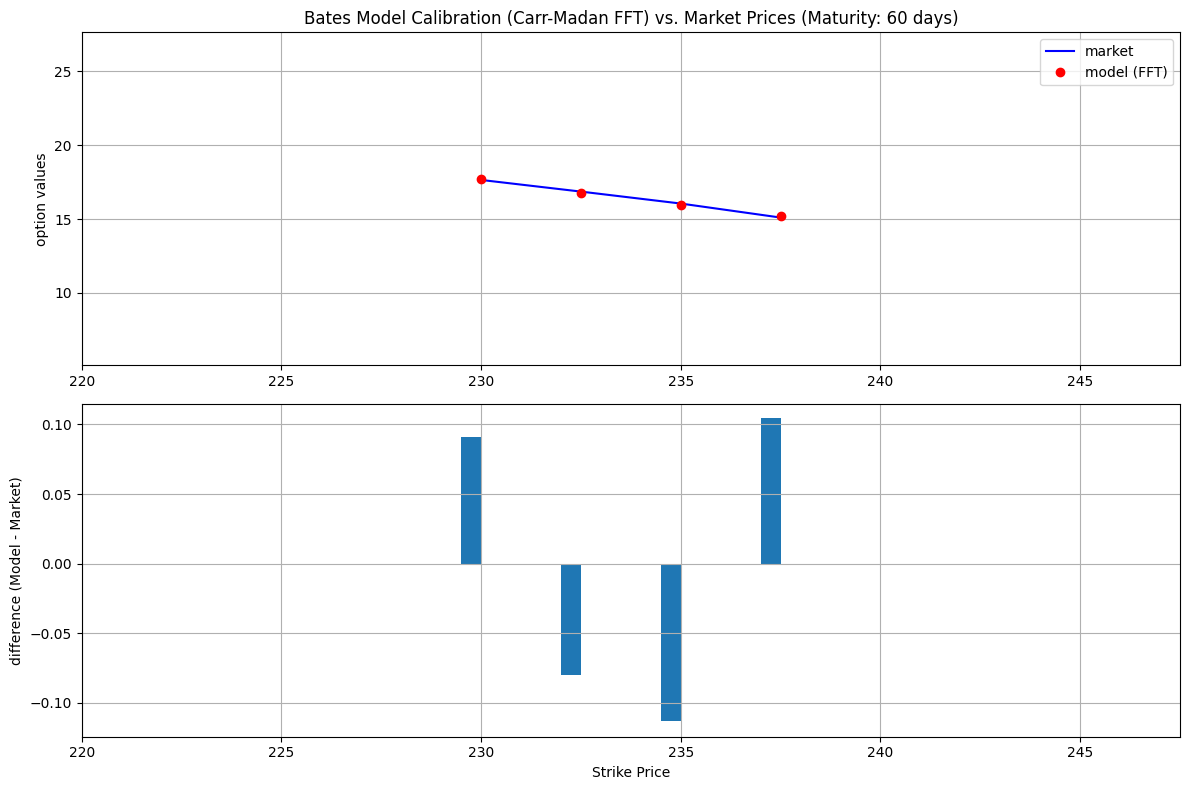

In [ ]:
# Plot the calibration results
plot_calibration_results_fft(calibrated_params_fft)

In [ ]:
"Empty Space Separation"

'Empty Space Separation'

## **STEP 2C**

In [ ]:
def asian_option_heston_mc(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N=250, M=10000):
    # Prce path S(t) with Heston
    S = heston_paths(S0, v0, kappa_v, theta_v, sigma_v, rho, r, T, N, M)
    # Mean
    S_avg = S.mean(axis=1)
    # Payoff Asian Call
    payoff = np.maximum(S_avg - K, 0)
    #Present value
    asian_price = np.exp(-r * T) * payoff.mean()
    return asian_price


In [ ]:
def heston_paths(S0, v0, kappa_v, theta_v, sigma_v, rho, r, T, N, M):
    dt = T / N
    S = np.zeros((M, N + 1))
    v = np.zeros((M, N + 1))
    S[:, 0] = S0
    v[:, 0] = v0
    for t in range(1, N + 1):
        Z1 = np.random.normal(size=M)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)
        v[:, t] = np.maximum(
            v[:, t-1] + kappa_v * (theta_v - v[:, t-1]) * dt +
            sigma_v * np.sqrt(np.maximum(v[:, t-1], 0) * dt) * Z1, 0
        )
        S[:, t] = S[:, t-1] * np.exp(
            (r - 0.5 * v[:, t-1]) * dt + np.sqrt(np.maximum(v[:, t-1], 0) * dt) * Z2
        )
    return S

In [ ]:
import numpy as np

# Parameters
S_ini = 232.90
K = 0.95 * S_ini
r = 0.015
T = 70 / 365
N = 70
M = 100000

# Heston model parameters
#kappa = FFT_values[0]
#theta = FFT_values[1]
#sigma = FFT_values[2]
#rho = FFT_values[3]
#v0 = FFT_values[4]

kappa = full_params[0]
theta = full_params[1]
sigma = full_params[2]
rho = full_params[3]
v0 = full_params[4]


dt = T / N


In [ ]:
asian_option_price = asian_option_heston_mc(S0, K, T, r, kappa, theta, sigma, rho, v0, N, M)

print(f"Asian option price under Heston model: {asian_option_price:.4f}")

Asian option price under Heston model: 12.9953


## Part 3: Interest Rate Modeling (Step 3 - Team Task)

**Objective:**

To account for interest rate risk, the team must calibrate a CIR (1985) model to the current Euribor term structure. After calibration, the model is used to simulate future interest rate paths.

**Methodology: CIR Calibration and Simulation**

First, we build a continuous term structure from the discrete Euribor rates using cubic spline interpolation. We then calibrate the CIR model's parameters ($\kappa, \theta, \sigma$) by fitting the model's theoretical bond prices to the market curve. Finally, we perform a large-scale Monte Carlo simulation of the short-rate process to forecast its value and range in one year.

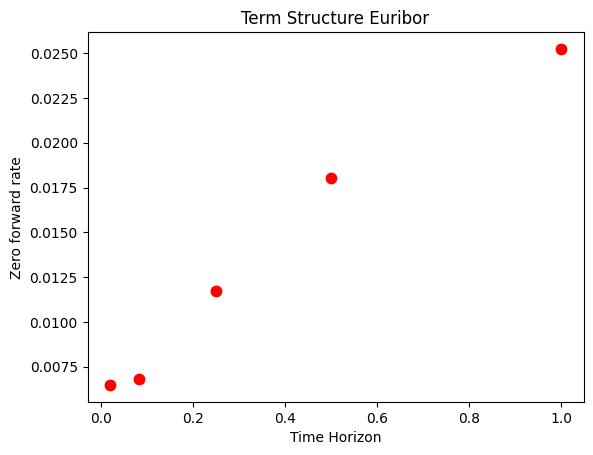

In [ ]:
from scipy.interpolate import CubicSpline
from scipy.optimize import fmin

mat_list = np.array((7, 30, 90, 180, 360))/360
rate_list = np.array((0.00648, 0.00679, 0.01173, 0.01809, 0.02556))


r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()


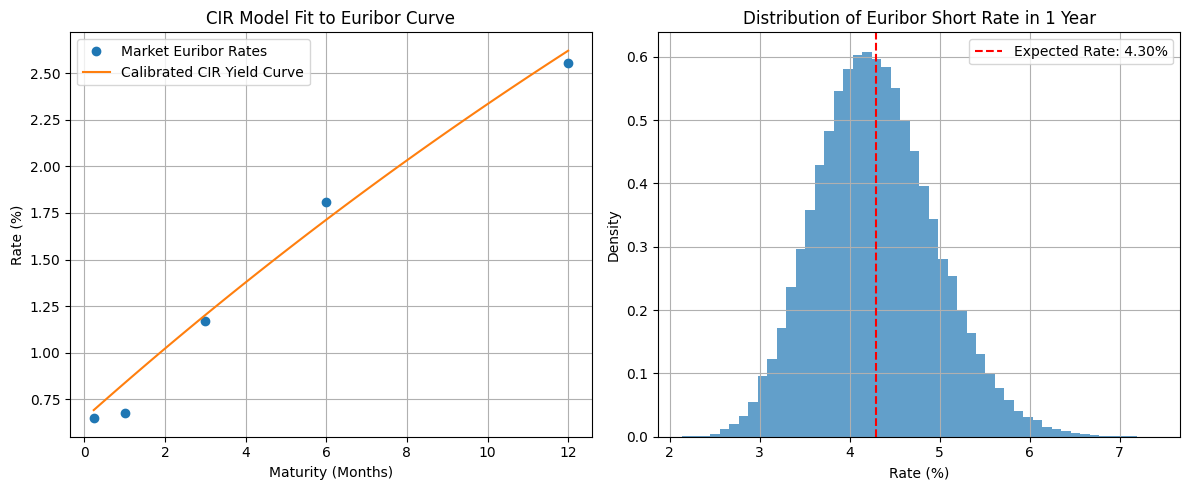

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# --- 1. Define Market Data and Interpolate ---
euribor_maturities = np.array([1/52, 1/12, 3/12, 6/12, 12/12]) # In years
euribor_rates = np.array([0.00648, 0.00679, 0.01173, 0.01809, 0.02556])

cs = CubicSpline(euribor_maturities, euribor_rates)
interp_maturities = np.linspace(1/52, 1, 52) # Weekly rates for 1 year
interp_rates = cs(interp_maturities)
r0 = euribor_rates[0] # Initial short rate

# --- 2. Define CIR Model and Objective Function ---
def cir_A(t, T, kappa, theta, sigma):
    gamma = np.sqrt(kappa**2 + 2*sigma**2)
    return ((2*gamma*np.exp((kappa+gamma)*(T-t)/2)) / ((gamma+kappa)*(np.exp(gamma*(T-t))-1)+2*gamma))**(2*kappa*theta/sigma**2)

def cir_B(t, T, kappa, theta, sigma):
    gamma = np.sqrt(kappa**2 + 2*sigma**2)
    return (2*(np.exp(gamma*(T-t))-1)) / ((gamma+kappa)*(np.exp(gamma*(T-t))-1)+2*gamma)

def cir_bond_price(t, T, r_t, kappa, theta, sigma):
    A = cir_A(t, T, kappa, theta, sigma)
    B = cir_B(t, T, kappa, theta, sigma)
    return A * np.exp(-B * r_t)

def cir_objective_function(params, maturities, rates):
    kappa, theta, sigma = params
    model_prices = cir_bond_price(0, maturities, r0, kappa, theta, sigma)
    model_rates = -np.log(model_prices) / maturities
    return np.mean((rates - model_rates)**2)

# --- 3. Calibrate CIR Model ---
initial_params = [0.2, 0.03, 0.05]
bounds = [(0.01, 1), (0.01, 0.1), (0.01, 0.2)]
cir_result = minimize(cir_objective_function, initial_params, args=(interp_maturities, interp_rates), bounds=bounds)
kappa_c, theta_c, sigma_c = cir_result.x

# --- 4. Simulate Future Rates ---
N_SIMS_CIR = 100000
N_STEPS_CIR = 250
T_CIR = 1.0
dt_cir = T_CIR / N_STEPS_CIR

rates_sim = np.full((N_SIMS_CIR, N_STEPS_CIR + 1), r0)
for i in range(N_STEPS_CIR):
    dW = np.random.standard_normal(N_SIMS_CIR) * np.sqrt(dt_cir)
    dr = kappa_c * (theta_c - rates_sim[:, i]) * dt_cir + sigma_c * np.sqrt(rates_sim[:, i]) * dW
    rates_sim[:, i+1] = np.abs(rates_sim[:, i] + dr)

final_rates = rates_sim[:, -1]
expected_rate_1y = np.mean(final_rates)
conf_level = 0.95
lower_bound = np.percentile(final_rates, (1-conf_level)/2 * 100)
upper_bound = np.percentile(final_rates, (1-(1-conf_level)/2) * 100)

# --- 5. Visualize Results ---
model_prices_final = cir_bond_price(0, interp_maturities, r0, kappa_c, theta_c, sigma_c)
model_rates_final = -np.log(model_prices_final) / interp_maturities

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(euribor_maturities*12, euribor_rates*100, 'o', label='Market Euribor Rates')
plt.plot(interp_maturities*12, model_rates_final*100, '-', label='Calibrated CIR Yield Curve')
plt.title('CIR Model Fit to Euribor Curve')
plt.xlabel('Maturity (Months)')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(final_rates*100, bins=50, density=True, alpha=0.7)
plt.axvline(expected_rate_1y*100, color='r', linestyle='--', label=f'Expected Rate: {expected_rate_1y:.2%}')
plt.title('Distribution of Euribor Short Rate in 1 Year')
plt.xlabel('Rate (%)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **3B**

In [ ]:
from scipy.interpolate import splev, splrep

bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

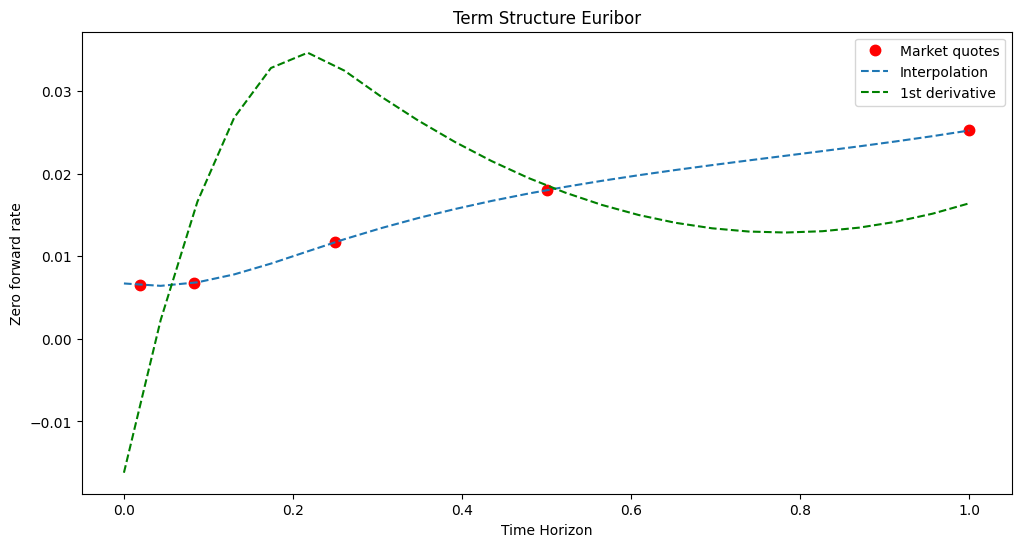

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """
    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 161
         Function evaluations: 288


array([0.98908305, 0.10863186, 0.00100074])

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

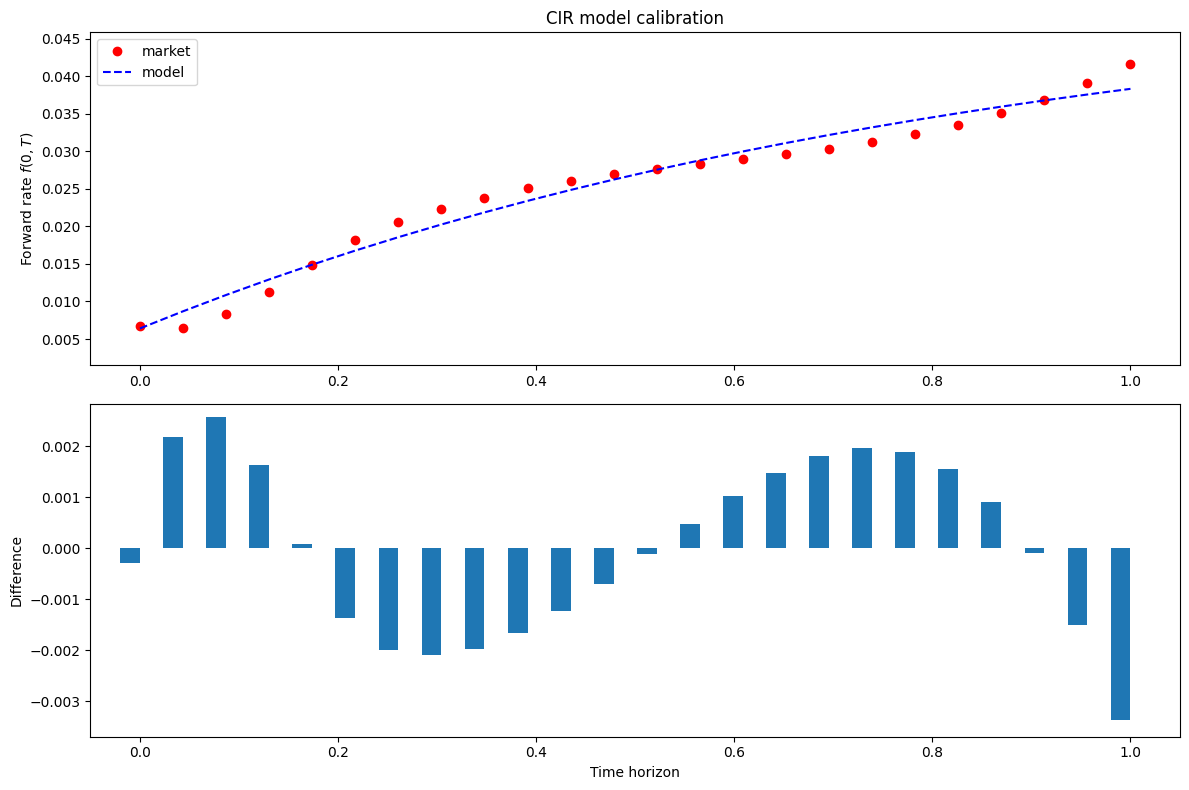

In [ ]:
plot_calibrated_frc(params)

# **STEP 3B**

In [ ]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [ ]:
k, theta, sigma = params
print (k, theta, sigma )
M = 100000  # Number of paths for MC
N = 360# Number of steps
T = 1  # Maturity
r0=1.5/100
rates_cir = cir(r0, k, theta, sigma, T, N, M)

0.9890830469294195 0.10863186174786685 0.0010007393949653491


In [ ]:
rates_cir

array([[0.015     , 0.015     , 0.015     , ..., 0.015     , 0.015     ,
        0.015     ],
       [0.015255  , 0.0152662 , 0.01526146, ..., 0.01524684, 0.01526065,
        0.01526464],
       [0.01551978, 0.01552882, 0.01552294, ..., 0.01549001, 0.01551802,
        0.01552677],
       ...,
       [0.0738144 , 0.07356524, 0.07363514, ..., 0.07377252, 0.0737143 ,
        0.07346733],
       [0.07391302, 0.07365511, 0.07375635, ..., 0.07387332, 0.07379575,
        0.07354995],
       [0.07402032, 0.07375978, 0.07385594, ..., 0.07399041, 0.07388272,
        0.07364807]])

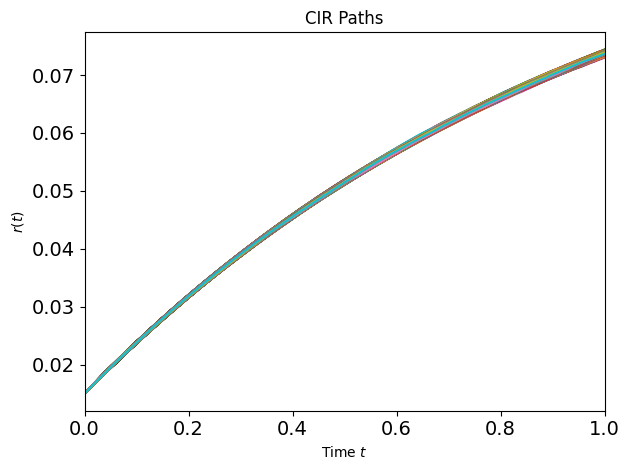

In [ ]:
t = np.linspace(0, T, N)
for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$")
plt.ylabel("$r(t)$")
plt.title("CIR Paths")
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# i. Level of confidence 95%
lower = np.percentile(rates_cir, 2.5)
upper = np.percentile(rates_cir, 97.5)
print(f"Level of confidence 95%: {lower:.4f} – {upper:.4f}")

# ii. The expected value of the 12-month Euribor in 1 year
expected = np.mean(rates_cir)
print(f"Expected value of the 12-month Euribor in 1 year: {expected:.4f}")

# iii. Expected number affect the pricing of your products in 1 year versus the current 12-month Euribor rate
print(f"The current 12-month Euribor rate: {r0:.4f}")

Level of confidence 95%: 0.0172 – 0.0729
Expected value of the 12-month Euribor in 1 year: 0.0491
The current 12-month Euribor rate: 0.0150


In [ ]:
def asian_option_mc(S_ini, K, T, r, sigma, N, M):
    """
    Calculate the price of an Asian call option using Monte Carlo simulation.

    Parameters:
    S_ini (float): Initial stock price.
    K (float): Strike price.
    T (float): Time to maturity in years.
    r (float): Risk-free rate.
    sigma (float): Volatility of the underlying asset.
    N (int): Number of time steps.
    M (int): Number of Monte Carlo paths.

    Returns:
    tuple: A tuple containing:
        - S (numpy.ndarray): Array of simulated stock prices.
        - asian_price (numpy.ndarray): Array of discounted Asian option payoffs for each path.
    """
    dt = T / N
    S = np.zeros((N + 1, M))
    S[0, :] = S_ini
    for i in range(1, N + 1):
        z = np.random.standard_normal(M)
        S[i, :] = S[i - 1, :] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Calculate the average price for each path
    average_price = np.mean(S[1:, :], axis=0)

    # Calculate the payoff for each path
    payoff = np.maximum(average_price - K, 0)

    # Discount the payoff to get the present value
    discounted_payoff = np.exp(-r * T) * payoff

    return S, discounted_payoff

### Discussion of Results

The expected value of the short rate in one year is around **4.30%-4.91%**, which is higher than the current 12-month rate of 2.56%. This indicates a market expectation of rising rates.

- **Impact on Future Pricing:** This expected increase in interest rates will directly affect the pricing of new products in one year. A higher risk-free rate leads to heavier discounting of future cash flows. This means:
    - **Call options** will become cheaper.
    - **Put options** will become more expensive.
    - The firm's valuation of fixed-income instruments will also need to be adjusted accordingly.